In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
df_salario = pd.read_csv('./datasets/salario.csv')

In [32]:
df_salario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [33]:
df_eda = df_salario.copy()
df_bucketing = df_salario.copy()

### EDA

In [34]:
df_eda.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20
5,105,10,12102.18
6,80,3,5723.35
7,85,2,6424.92
8,66,5,3916.18
9,73,5,4751.79


In [35]:
# Detectar valores ausente
df_eda.isna().sum()

tempo_na_empresa    0
nivel_na_empresa    0
salario_em_reais    0
dtype: int64

In [36]:
df_eda.describe()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


<Axes: ylabel='tempo_na_empresa'>

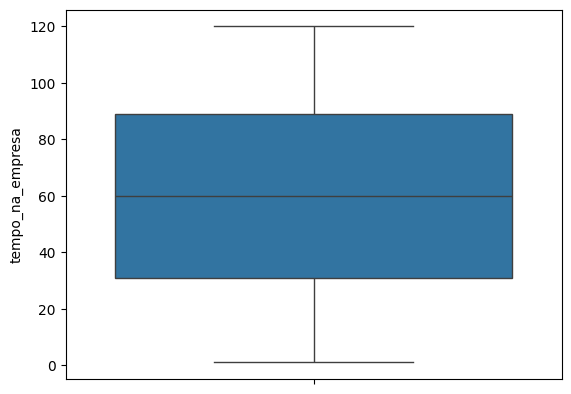

In [37]:
# Verificar outliers
sns.boxplot(data=df_eda, y='tempo_na_empresa')

<Axes: ylabel='nivel_na_empresa'>

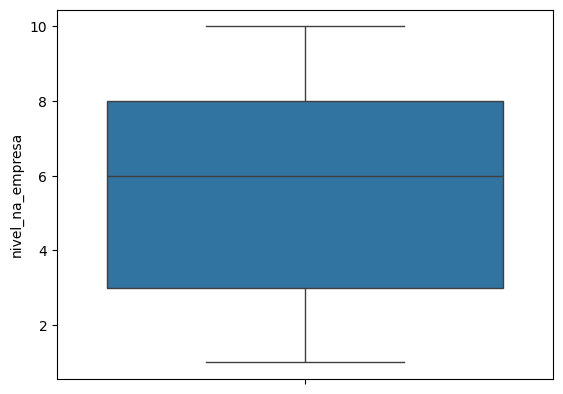

In [38]:
sns.boxplot(data=df_eda, y='nivel_na_empresa')

<Axes: ylabel='salario_em_reais'>

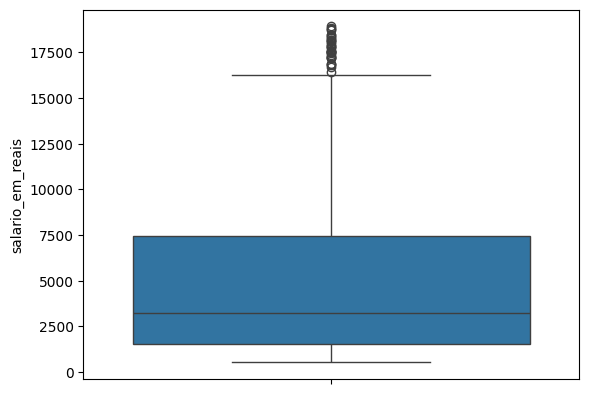

In [39]:
sns.boxplot(data=df_eda, y='salario_em_reais')

<Axes: xlabel='tempo_na_empresa', ylabel='salario_em_reais'>

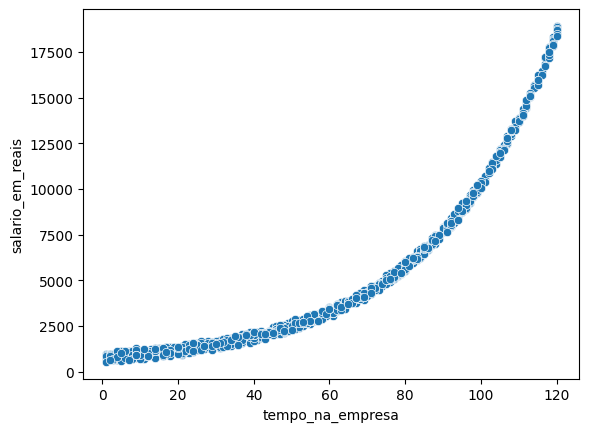

In [40]:
# Cruzamento variáveis numéricas com salário em reais (variavel dependente)
sns.scatterplot(data=df_eda, x='tempo_na_empresa', y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='salario_em_reais'>

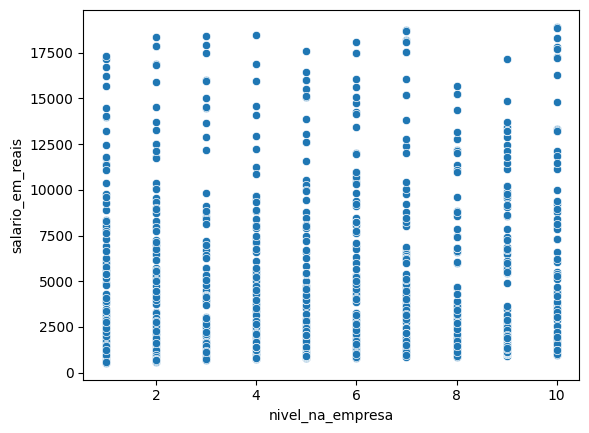

In [41]:
sns.scatterplot(data=df_eda, x='nivel_na_empresa', y='salario_em_reais')

<Axes: xlabel='tempo_na_empresa', ylabel='nivel_na_empresa'>

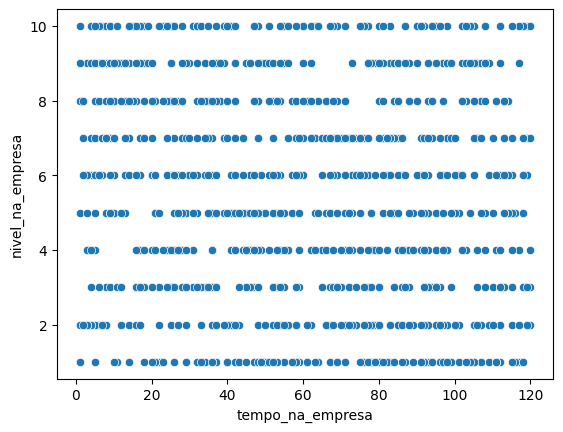

In [42]:
sns.scatterplot(data=df_eda, x='tempo_na_empresa', y='nivel_na_empresa')

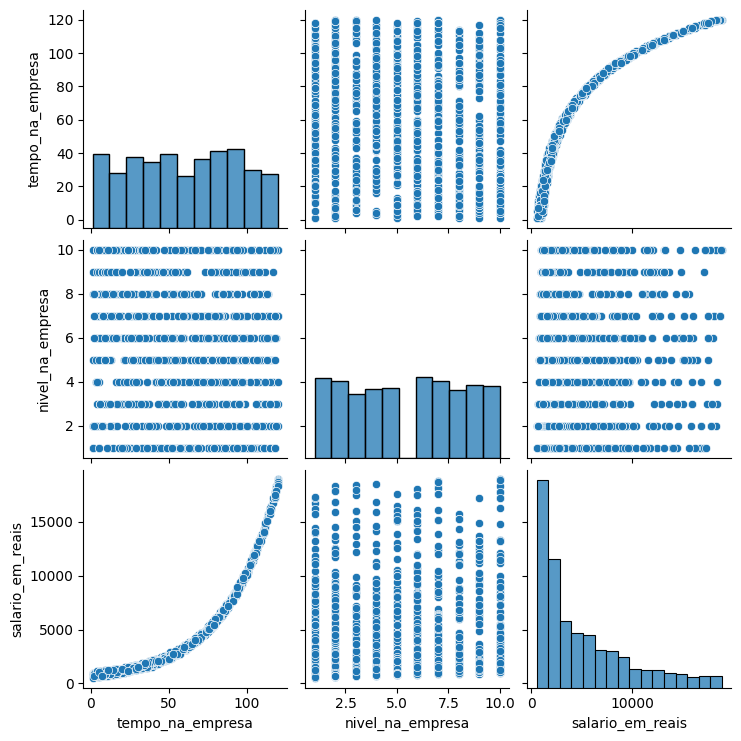

In [43]:
sns.pairplot(df_eda)

<Axes: >

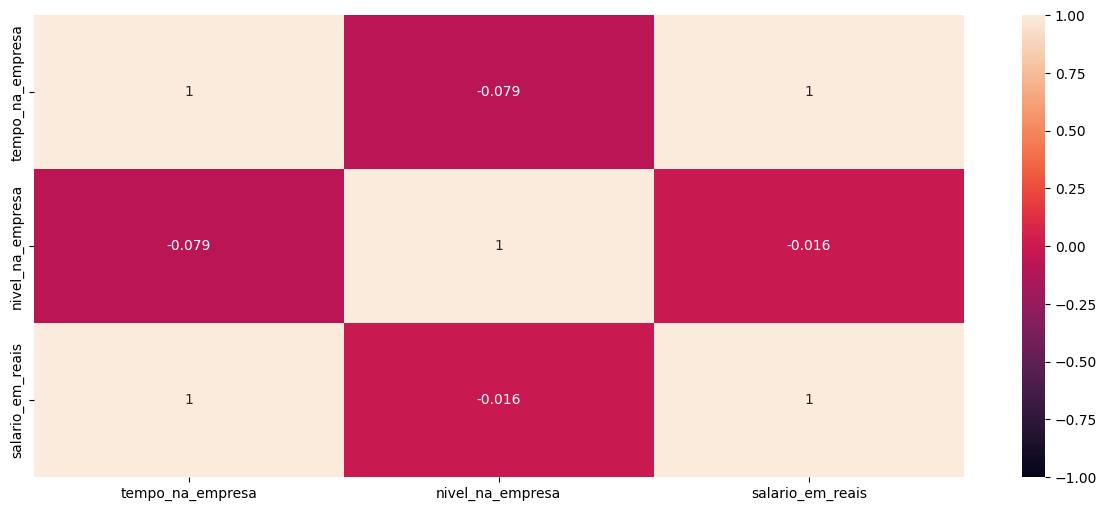

In [44]:
plt.figure(figsize=(15,6))
sns.heatmap(df_eda.corr('spearman'), vmin = -1, vmax = 1, annot = True)

<Axes: >

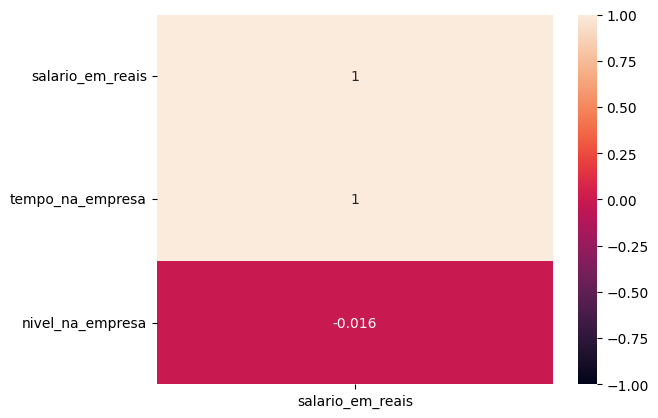

In [45]:
sns.heatmap(df_eda.corr('spearman')[['salario_em_reais']].sort_values(by='salario_em_reais', ascending=False), vmin=-1, vmax=1, annot=True)

In [46]:
bins_tempo_casa = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
labels_tempo_casa = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119', '120-129']
df_bucketing['escala_tempo'] = pd.cut(x=df_bucketing['tempo_na_empresa'], bins=bins_tempo_casa, labels=labels_tempo_casa, include_lowest=True)

In [47]:
df_bucketing.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais,escala_tempo
0,50,1,2288.13,40-49
1,49,4,2389.84,40-49
2,39,10,2158.73,30-39
3,51,1,2341.06,50-59
4,62,7,3584.20,60-69
5,105,10,12102.18,100-109
6,80,3,5723.35,70-79
7,85,2,6424.92,80-89
8,66,5,3916.18,60-69
9,73,5,4751.79,70-79


<Axes: xlabel='escala_tempo', ylabel='salario_em_reais'>

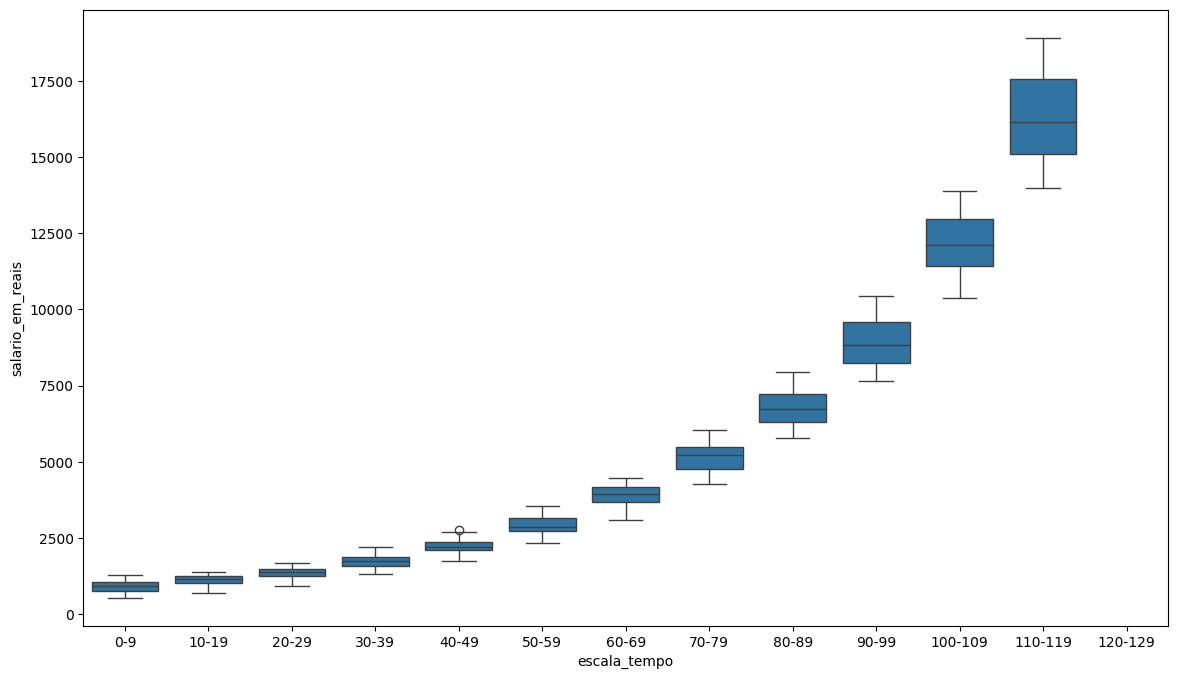

In [48]:
plt.figure(figsize=(14,8))
sns.boxplot(df_bucketing, x = 'escala_tempo', y = 'salario_em_reais')

### Treinar modelo linear

In [49]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

import numpy as np

In [50]:
x = df_salario.drop(columns='salario_em_reais')
y = df_salario['salario_em_reais']


In [51]:
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [53]:
# Bloco treinamento do modelo

# Pipeline
# Padronizar variáveis numericas - tempo_na_emopresa, nivel_na_empresa
# Nome das Colunas
colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

# Transformer para Colunas numerias
tranformer_numericas = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Criar um ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', tranformer_numericas, colunas_numericas)
    ]
)

# Criando o Pipeline principal = Pré-processamento + treinamento
model_reg_lin = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regression', LinearRegression())])

# Armazenar RMSE Treino e Teste
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Armazenar R2 Score de Teste
r2score_fold_test = []

# Armazenar residuos
residuos = []

# Armazenar predições
y_pred_total = []

for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Treinando o modelo no conjunto de treino
model_reg_lin.fit(x_train, y_train)

# Fazendo predições nos conjuntos de treinamento e teste
y_train_pred = model_reg_lin.predict(x_train)
y_test_pred = model_reg_lin.predict(x_test)


# Calculando RMSE para os conjuntos de treino

rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

# Calculando R2Score e residuos para conjunto de teste
r2score_test = r2_score(y_test, y_test_pred)
residuos_test = np.array(y_test-y_test_pred)

# Armazenando as métricas na lista
rmse_scores_fold_train.append(rmse_train)
rmse_scores_fold_test.append(rmse_test)
r2score_fold_test.append(r2score_test)
residuos.append(residuos_test)
y_pred_total.append(y_test_pred)